In [1]:
import numpy as np
import pandas as pd
import time
import sys
from matplotlib import pyplot as plt
%matplotlib inline

# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,auc

In [2]:
#get data
in_file = '../../merge/reformatted_data_with_features.txt'
training_samples_path = "../../../../../metadata/cancer_detection/delfi_training_samples.txt"
feature_type = 'DHS'
metadata_columns = ['tumor_fraction','cancer_present','sample_type','Stage']

data = pd.read_csv(in_file, sep='\t')

data = data.set_index('sample')
data['status'] = data['cancer_present']

#get only the training samples used in delfi
training_samples = pd.read_csv(training_samples_path, header=None)
data = data[data.index.isin(training_samples[0])].copy()

print(len(data))
print(data['sample_type'].value_counts())


423
Healthy              215
Breast_Cancer         54
Pancreatic_Cancer     34
Ovarian_Cancer        28
Gastric_cancer        27
Colorectal_Cancer     27
Bile_Duct_Cancer      25
Lung_Cancer           12
Duodenal_Cancer        1
Name: sample_type, dtype: int64


In [3]:
#view data
data.head()

,tumor_fraction,sample_type,cancer_present,Stage,central_cov_Cancer_epithelial_DHS.top_10000,central_cov_Cardiac_DHS.top_10000,central_cov_Digestive_DHS.top_10000,central_cov_Lymphoid_DHS.top_10000,central_cov_Musculoskeletal_DHS.top_10000,central_cov_Myeloid_erythroid_DHS.top_10000,...,mean_cov_Organ_devel_renal_DHS.top_10000,mean_cov_Placental_trophoblast_DHS.top_10000,mean_cov_Primitive_embryonic_DHS.top_10000,mean_cov_Pulmonary_devel_DHS.top_10000,mean_cov_Renal_cancer_DHS.top_10000,mean_cov_Stromal_A_DHS.top_10000,mean_cov_Stromal_B_DHS.top_10000,mean_cov_Tissue_invariant_DHS.top_10000,mean_cov_Vascular_endothelial_DHS.top_10000,status
sample,,,,,,,,,,,,,,,,,,,,,
Bile_Duct_Cancer_CGPLPA114,0.00000,Bile_Duct_Cancer,1,II,1.100060,1.044908,1.069182,0.865475,1.005175,0.902967,...,0.978594,0.992712,0.932252,0.990849,0.995766,0.984277,0.931341,0.802761,0.994277,1
Bile_Duct_Cancer_CGPLPA115,0.14790,Bile_Duct_Cancer,1,IV,1.089240,1.040337,1.073515,0.893862,1.008112,0.919885,...,0.978891,0.997319,0.944799,0.995883,0.996664,0.980089,0.940119,0.830701,0.999758,1
Bile_Duct_Cancer_CGPLPA117,0.00000,Bile_Duct_Cancer,1,II,1.060242,1.029103,1.035042,0.834612,1.032305,0.893125,...,0.984077,0.996806,0.935510,0.999831,0.999860,0.985445,0.936656,0.808757,0.992506,1
Bile_Duct_Cancer_CGPLPA118,0.03099,Bile_Duct_Cancer,1,I,1.084718,1.053315,1.050678,0.878805,1.024810,0.932040,...,0.976552,0.999934,0.927146,0.994912,1.000629,0.989279,0.928462,0.787961,0.999960,1
Bile_Duct_Cancer_CGPLPA122,0.04570,Bile_Duct_Cancer,1,II,1.125692,1.059490,1.030080,0.907608,1.027252,0.970550,...,0.970679,0.998169,0.925820,0.987487,0.997210,0.978530,0.919225,0.789960,0.999908,1


In [4]:
#get a list of all possible features
features = data.columns.drop(['status']+metadata_columns)

#these two should be the seame
print(len(features))
print(len(features[features.str.contains('fft_10_magnitude')])*3)

48
48


In [5]:
#scale data
scaler = StandardScaler()
scaler.fit(data[features])
data[features] = scaler.transform(data[features])
data[features].mean()

central_cov_Cancer_epithelial_DHS.top_10000             1.445652e-15
central_cov_Cardiac_DHS.top_10000                       1.592632e-15
central_cov_Digestive_DHS.top_10000                    -1.706476e-15
central_cov_Lymphoid_DHS.top_10000                     -3.768984e-16
central_cov_Musculoskeletal_DHS.top_10000               1.264552e-15
central_cov_Myeloid_erythroid_DHS.top_10000             4.740101e-16
central_cov_Neural_DHS.top_10000                        4.993641e-15
central_cov_Organ_devel_renal_DHS.top_10000             1.931211e-15
central_cov_Placental_trophoblast_DHS.top_10000        -5.292850e-15
central_cov_Primitive_embryonic_DHS.top_10000          -1.700767e-15
central_cov_Pulmonary_devel_DHS.top_10000              -6.733778e-15
central_cov_Renal_cancer_DHS.top_10000                 -1.217308e-15
central_cov_Stromal_A_DHS.top_10000                     2.244068e-15
central_cov_Stromal_B_DHS.top_10000                     4.055595e-15
central_cov_Tissue_invariant_DHS.t

In [6]:
#Leave one out nested cross validation
hyperparameters = {'C': [0.00001, 0.0001, 0.001,0.01,0.1,1,10,100]}

start_time = time.time()

# Loop for 1000 iterations
n_iter = 1000

probabilities = pd.DataFrame(index=data.index)
c_vals = []
coefs = pd.DataFrame(index=features)

for i in range(n_iter):
    if i%50==0:
        print(i, time.time()-start_time)
        sys.stdout.flush()
    
    #bootstrap a training set (sample with replacement)
    training = data.sample(len(data), replace = True, random_state = i+100)
    
    #the test set is all samples that aren't seen in the training data
    test = data[~(data.index.isin(training.index))]
        
    #10 fold cross validation on the training set
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = i+100) 

    model = LogisticRegression(class_weight='balanced', max_iter=500)
    search = GridSearchCV(estimator=model, param_grid=hyperparameters, cv=cv, n_jobs = 5)
    search.fit(training[features], training['status'])
    best_C = search.best_params_['C']
    
    #train a new model on the full training dataset (is this the same as refit...?)
    model = LogisticRegression(class_weight='balanced', max_iter=500, C=best_C)
    model.fit(training[features], training['status'])

    #predict the test data
    pred = model.predict(test[features])
    prob = model.predict_proba(test[features])

    
    #collect metrics
    current_output = pd.DataFrame(test[['status']])#.reset_index()
    current_output['probability']=prob[:,1]
    
    #save results
    probabilities[i] = current_output['probability']
    c_vals.append(best_C)
    coefs[i] = pd.Series(model.coef_[0], index = features)

probabilities = probabilities.merge(data[metadata_columns+['status']], left_index=True, right_index=True)

0 0.0012128353118896484
50 20.392439603805542
100 40.06985878944397
150 60.4882538318634
200 81.16067886352539
250 103.37095665931702
300 123.8673768043518
350 143.65999484062195
400 163.92774081230164
450 184.28947567939758
500 204.2871117591858
550 224.62411785125732
600 245.1286599636078
650 265.76416277885437
700 286.3614547252655
750 307.09311270713806
800 328.00850677490234
850 348.9515998363495
900 369.9531488418579
950 390.705885887146


In [7]:
probabilities.to_csv(feature_type+'_results/probabilities.txt', sep='\t')
pd.Series(c_vals).to_csv(feature_type+'_results/c_values.txt', sep='\t', header = False, index=False)
coefs.to_csv(feature_type+'_results/coefs.txt', sep='\t')

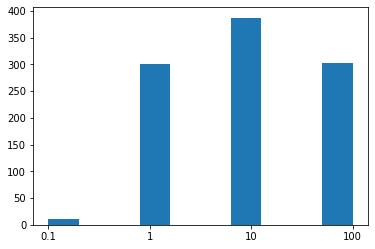

In [8]:
plt.hist([str(m) for m in sorted(c_vals)])
plt.savefig(feature_type+'_results/cvals.pdf')